### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
# Computational packages
import numpy as np
import matplotlib.pyplot as plt

# General packages
import sys
import tqdm

# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None 
from Models import SorscherRNN
from Experiment import Experiment
from methods import PCA_UMAP
from datahandling import *
from stats import *
from plotting_functions import scatter3d

import umap
from sklearn.cluster import DBSCAN 

import utils

from ripser import ripser
from persim import plot_diagrams

#from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
#kernel = Gaussian2DKernel(x_stddev=1,y_stddev=1).array
#ratemaps.append(interpolate_replace_nans(temp_maps, kernel[None]))

/Users/m/miniforge3/envs/ml/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/m/miniforge3/envs/ml/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/m/miniforge3/envs/ml/lib/python3.9/site-packages/umap/distances.py:1086: NumbaD

In [3]:
def calculate_orientation_shift(ratemap1, ratemap2, rotation_res=360):
    """
    calculate orientation shift between two ratemaps
    """
    autocorr1 = scipy.signal.correlate(ratemap1, ratemap1, mode="same")
    autocorr2 = scipy.signal.correlate(ratemap2, ratemap2, mode="same")

    # normalize the autocorrelations
    #autocorr1 = autocorr1 / np.sum(autocorr1)
    #autocorr2 = autocorr2 / np.sum(autocorr2)
    # slice out the largest disk that fits in the autocorrelation
    disk_mask = make_disk_mask(autocorr1.shape[0])
    rotations = np.linspace(-np.pi, np.pi, rotation_res)
    scores = []
    for rotation in rotations:
        rotated_autocorr2 = scipy.ndimage.rotate(autocorr2, np.degrees(rotation), reshape=False, order=0)
        score = np.corrcoef(autocorr1[disk_mask], rotated_autocorr2[disk_mask])[0,1]
        scores.append(score)    
    return scores, rotations[np.argmax(scores)], rotations


In [4]:
def cluster_modules_rot(corrs):
    """ Grid module identification, following Gardner et al.
    
    Procedure is to convert low-res. ratemaps to a matrix
    of shape (n_cells, n_bins), then do a 2D UMAP of this matrix.
    
    Clustering is then performed on the low-dimensional representation.
    Clustering uses DBSCAN.
    returns 
    """
    
    low_dim = []
    cluster_labels = []
    for i in range(len(corrs)):
        transform = umap.UMAP(metric = "euclidean", n_neighbors = 20, min_dist = 0.05, init = "spectral")
        low_dim.append(transform.fit_transform(corrs[i]))
        clustering = DBSCAN(min_samples = 30, eps = 0.5).fit(low_dim[-1])
        cluster_labels.append(clustering.labels_)
    return low_dim, cluster_labels


In [5]:
# load a model to create low res ratemaps
#base_path = "/home/users/vemundss/"
base_path = "../"
experiment = utils.load_experiment(base_path, "gg-new")
model = utils.load_model(experiment)

# where to save indices of interesting cells
save_loc = f"{experiment.paths['experiment']}/"

Experiment <gg-new> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.
Loading model at epoch = 02999 ../data/emergent-grid-cells/gg-new/checkpoints/02999


In [6]:
n_envs = len(experiment.environments)

In [7]:
dataset = Dataset(agents = experiment.agents, pc_ensembles = experiment.pc_ensembles, num_samples = 1500, **experiment.params)

In [8]:
n = 10000 # number of trajectories 
acts, r, v = utils.run_model(model, dataset, range(n_envs), samples = n, start = 10)

100%|█████████████████████████████████████████████| 3/3 [01:19<00:00, 26.36s/it]


In [9]:
bins = 32
ratemaps = [utils.create_ratemaps(acts[0], r[0], res = [bins, bins])]
ratemaps = np.array(ratemaps)
[np.isnan(ratemaps[i]).sum() for i in range(len(ratemaps))]

[0]

In [10]:
# remove zero variance and spurious large rates
# remove cells that are completely off in any environment

accepted_maps = ratemaps[0] # only consider env 0
flat = np.nanvar(accepted_maps, axis = (-2, -1)) == 0
too_active = np.nanmean(accepted_maps, axis = (-2, -1)) > 0.15
mask = ~(too_active + flat).astype("bool") 
accepted_maps = accepted_maps[mask] 

# normalize 
stddev = np.std(accepted_maps, axis = (-2, -1), keepdims = True)
mean = np.mean(accepted_maps, axis = (-2, -1), keepdims = True)
accepted_maps = (accepted_maps - mean)/stddev

accepted_maps.shape

(3136, 32, 32)

In [11]:
# compute rotational correlation scores
scores = np.zeros((accepted_maps.shape[0], 360))

for i in tqdm.tqdm(range(accepted_maps.shape[0])):
    scores[i], _, rotations = calculate_orientation_shift(accepted_maps[i], accepted_maps[i])

100%|███████████████████████████████████████| 3136/3136 [01:13<00:00, 42.82it/s]


In [12]:
low_dim, labels = cluster_modules_rot([scores])
low_dim = low_dim[0]
labels = labels[0]

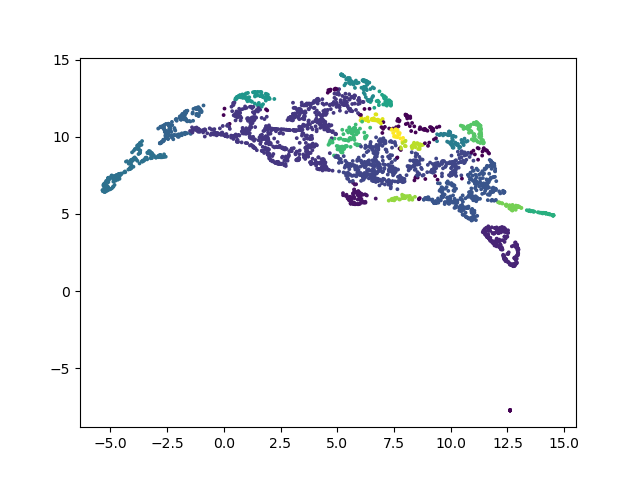

In [13]:
plt.close()
plt.figure()
plt.scatter(low_dim[:,0], low_dim[:,1], c = labels, s = 3)

In [14]:
cell_inds = [] 
descriptions = []

for label in np.unique(labels):
    selected = labels == label
    cell_inds.append(np.arange(model.Ng)[mask][selected])
    descriptions.append(f'rotation_cluster_{label}')

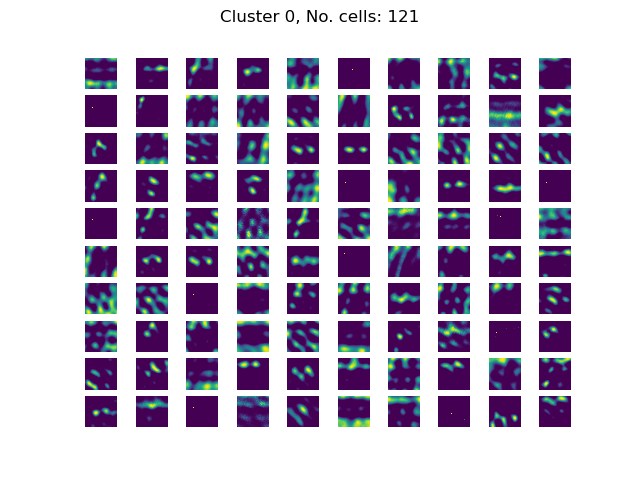

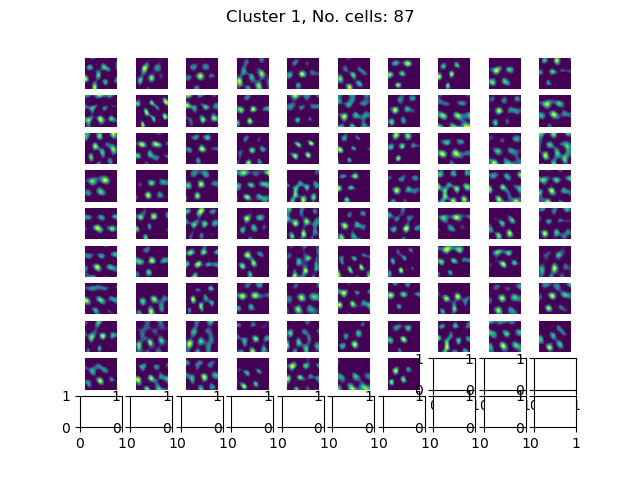

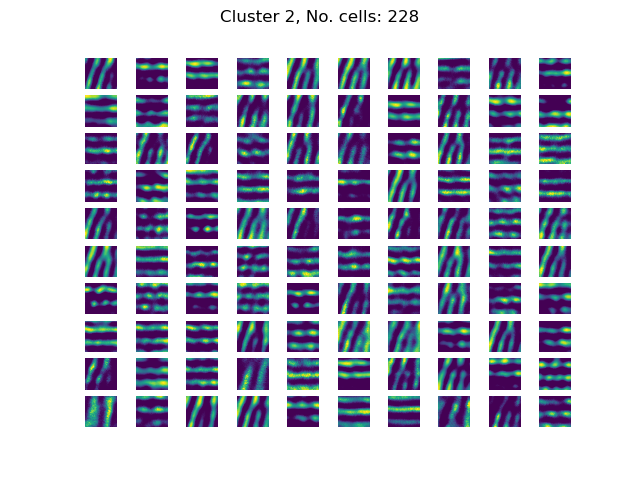

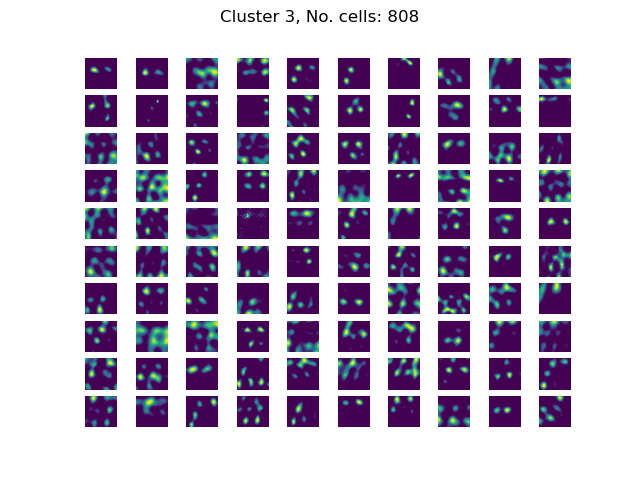

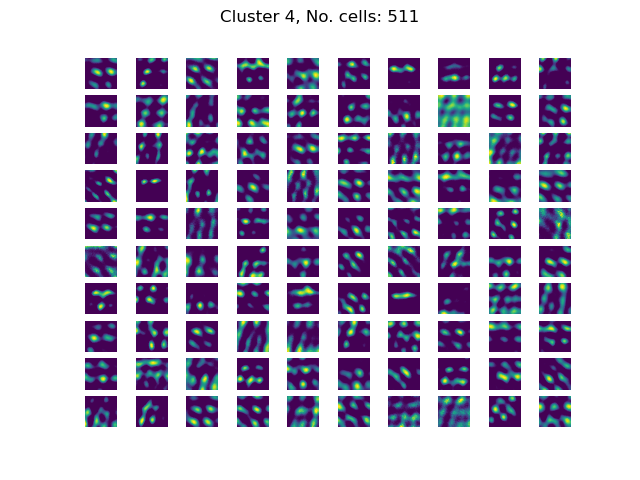

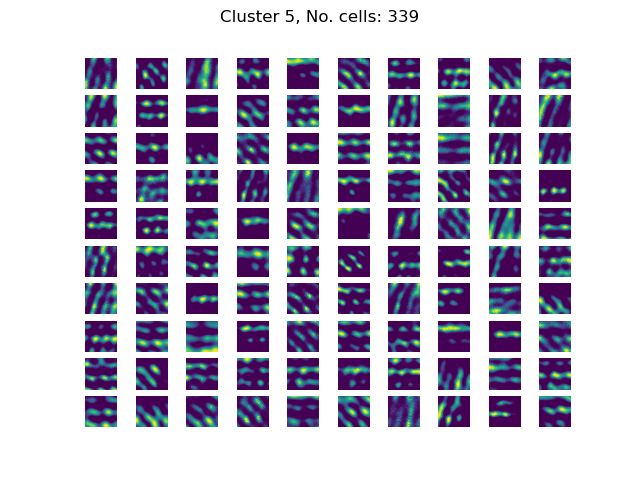

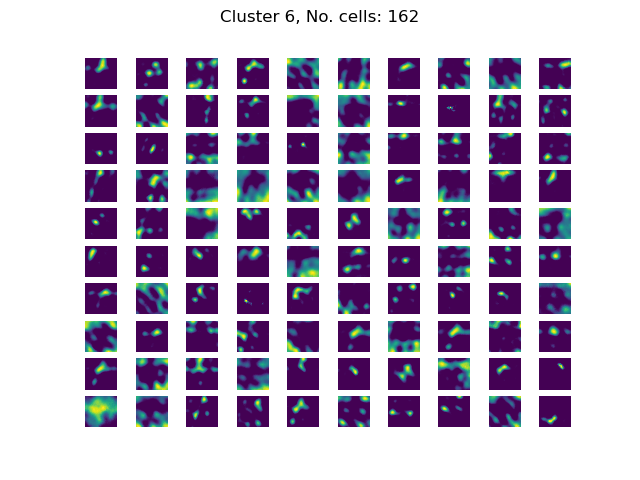

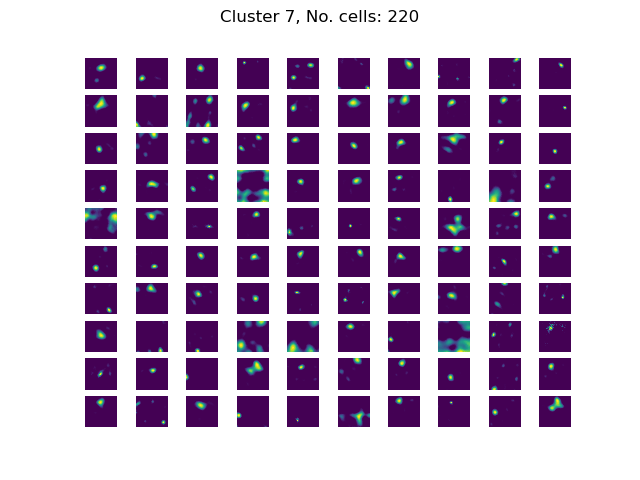

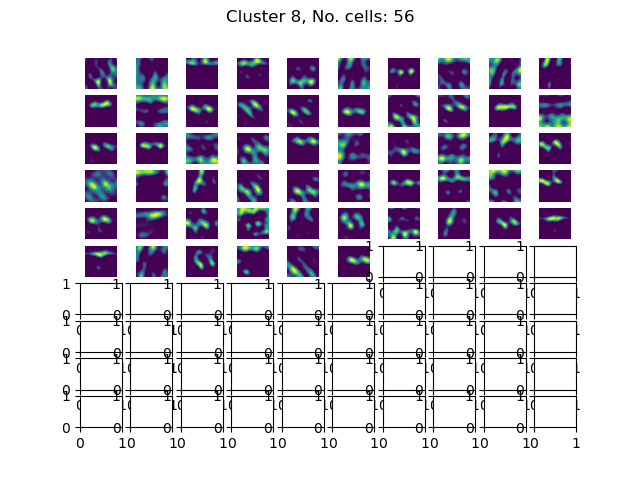

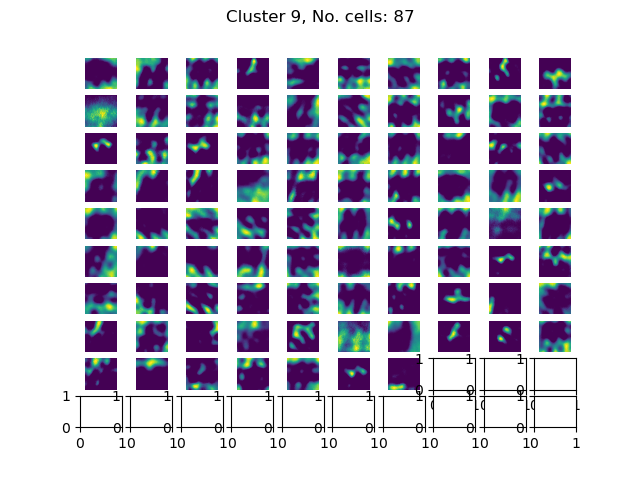

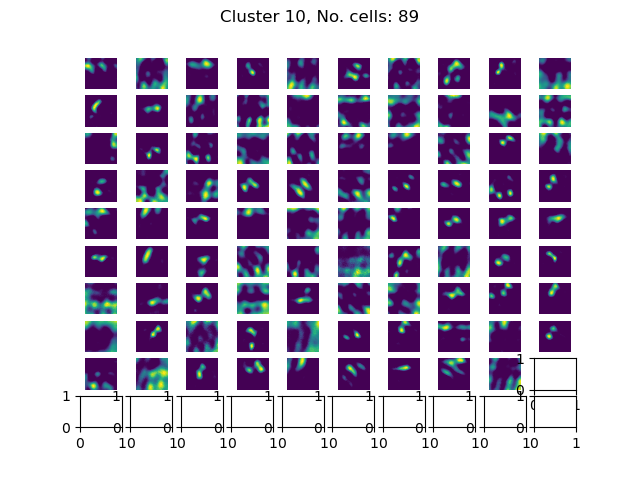

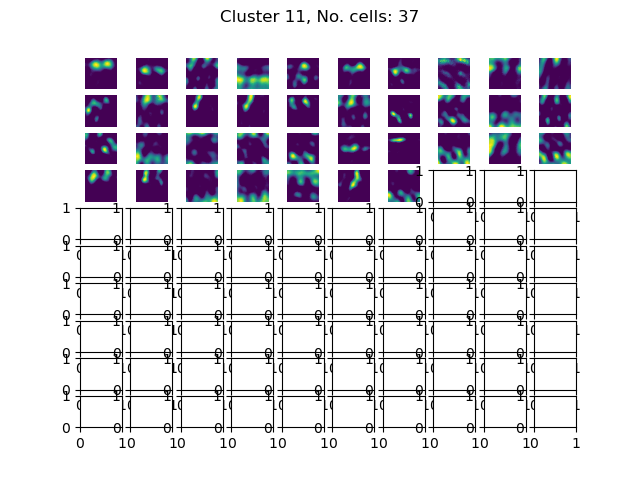

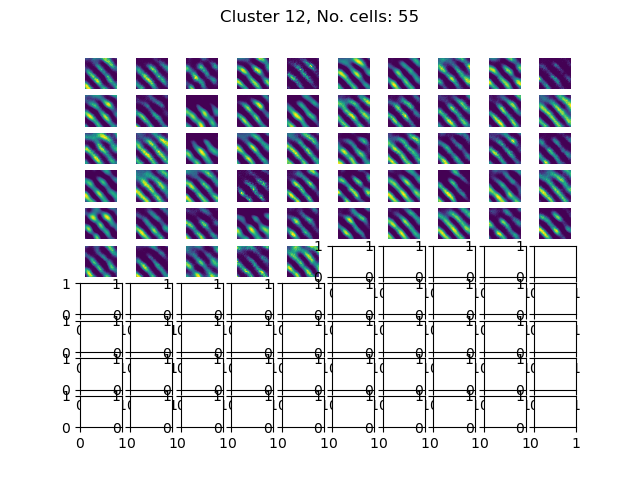

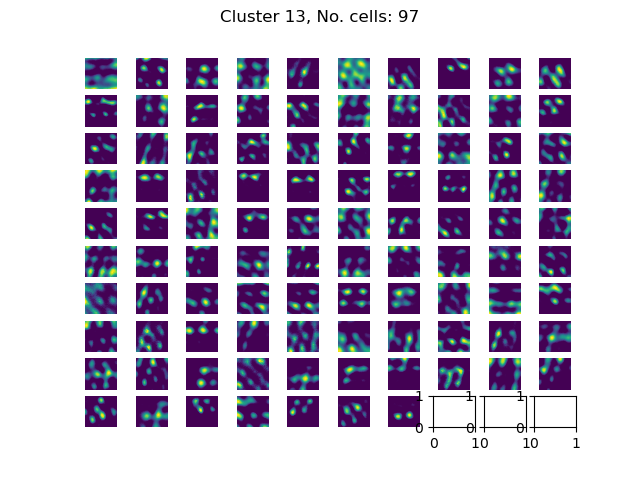

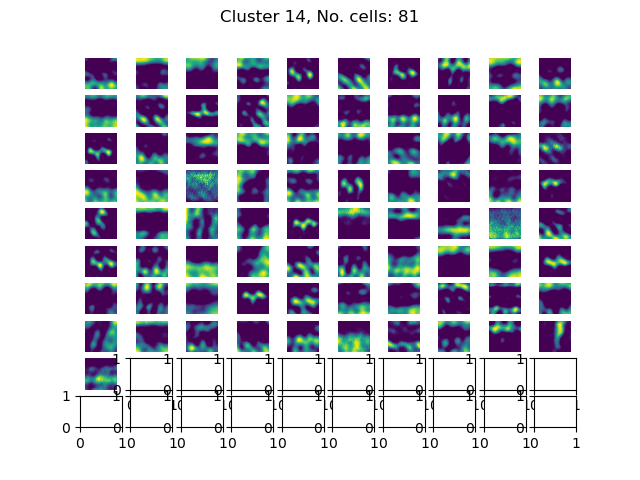

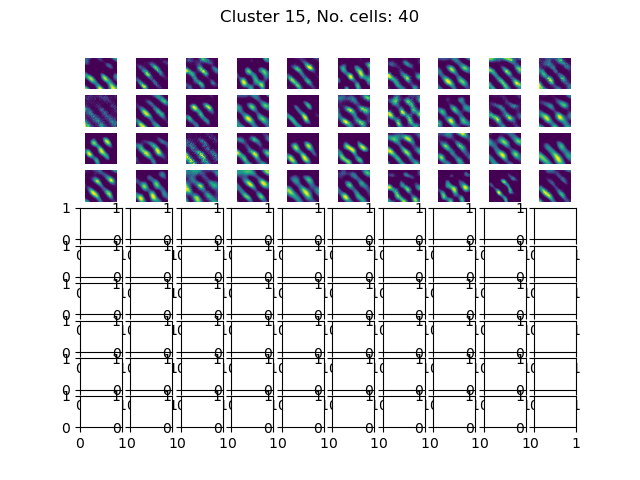

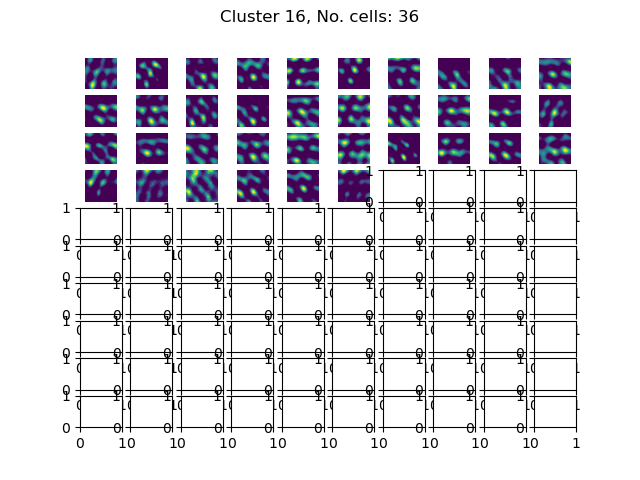

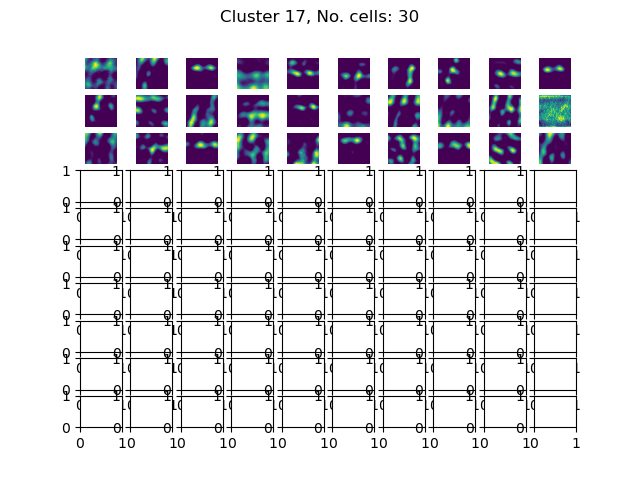

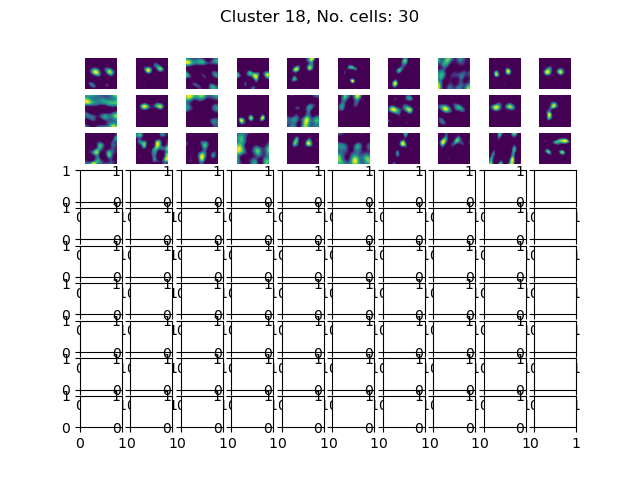

/var/folders/rv/mky69fln76nbwl7qkb06318h0000gn/T/ipykernel_3525/3419301111.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(10,10)


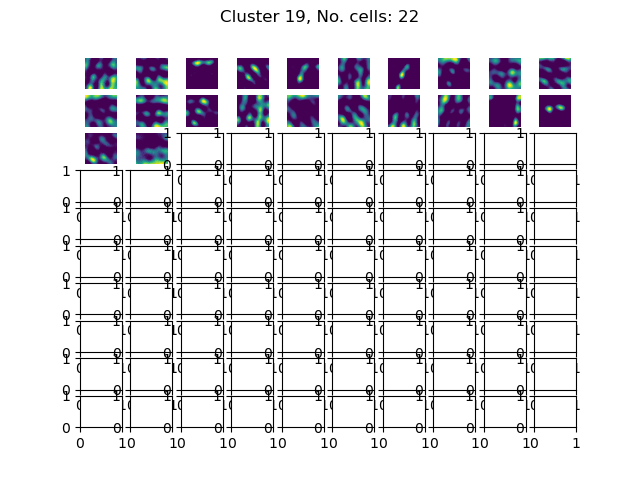

In [15]:
for i, inds in enumerate(cell_inds):

    show_maps = ratemaps[0][inds]

    fig, ax = plt.subplots(10,10)
    plt.suptitle(f"Cluster {i}, No. cells: {len(inds)}")
    for count in range(np.minimum(100, len(show_maps))):
        row = count // 10
        col = count % 10
        ax[row, col].imshow(show_maps[count])
        ax[row, col].axis("off")
        count += 1
    plt.show()

In [16]:
# And save for posterity
x = {descriptions[i]: cell_inds[i] for i in range(len(descriptions))}
#np.savez(f"{save_loc}module_indices_all_clusters", **x)

In [127]:
interesting_clusters = [2, 12, 15]

# higher res ratemaps for analysis
ratemaps = [utils.create_ratemaps(acts[0], r[0], res = [32, 32])]

concat_clusters = np.concatenate([ratemaps[0][cell_inds[ind]] for ind in interesting_clusters])
concat_clusters.shape

(323, 32, 32)

In [128]:
def upscale_ratemaps(ratemaps, res):
    x0, y0 = np.linspace(0, 2.2, ratemaps.shape[-2]), np.linspace(0, 2.2, ratemaps.shape[-1])
    x, y = np.linspace(0, 2.2, res[0]), np.linspace(0, 2.2, res[1])
    xx, yy = np.meshgrid(x,y)
    r = np.stack([xx.ravel(), yy.ravel()], axis = -1)
    from scipy.interpolate import RegularGridInterpolator
    
    high_res = np.zeros((ratemaps.shape[0], res[0], res[1]))
    
    for i in range(len(ratemaps)):
        interp = RegularGridInterpolator((x0, y0), ratemaps[i])(r)
        high_res[i] = interp.reshape(res)
    return high_res
    

In [129]:
concat_clusters = upscale_ratemaps(concat_clusters, [64, 64])

gc = concat_clusters.reshape(concat_clusters.shape[0], -1).T
gc = gc[~np.all(np.isnan(gc), axis = -1)]

18


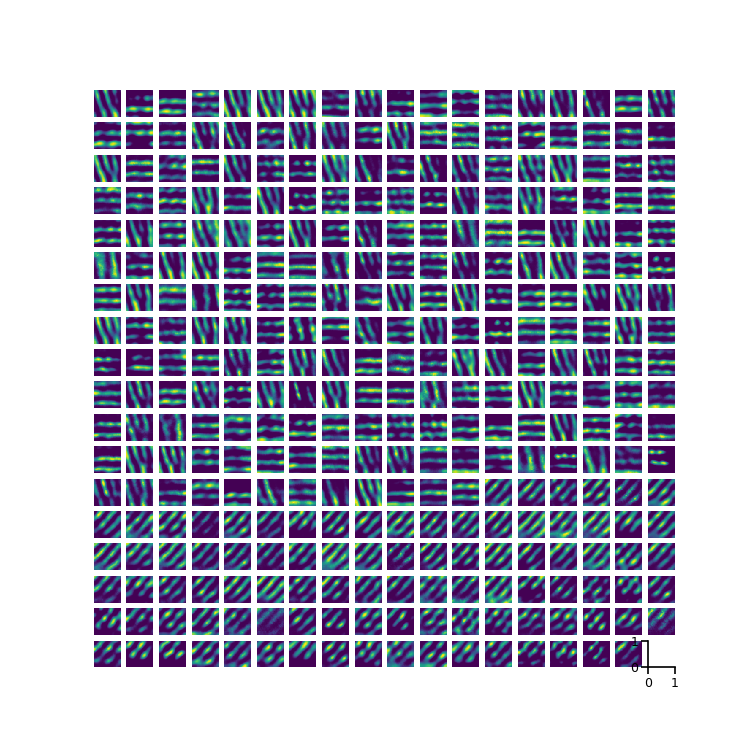

In [130]:
show_maps = concat_clusters

n = int(np.sqrt(len(show_maps))) + 1
print(n)
fig, ax = plt.subplots(n,n, figsize = (5,5))

for count in range(np.minimum(n*n, len(show_maps))):
    row = count // n
    col = count % n
    ax[row, col].imshow(show_maps[count].T, origin = "lower")
    ax[row, col].axis("off")
    count += 1
plt.show()

In [156]:
#pca_fit, u = PCA_UMAP(gc)

from sklearn.decomposition import PCA
import umap

pca_fit = PCA(n_components = 6).fit_transform(gc)
umap_fit = umap.UMAP(n_components = 3, min_dist = 0.8,  # Almost Gardner et al. params
                     n_neighbors = 4000, metric = "euclidean", init = "spectral")
u = umap_fit.fit_transform(pca_fit)

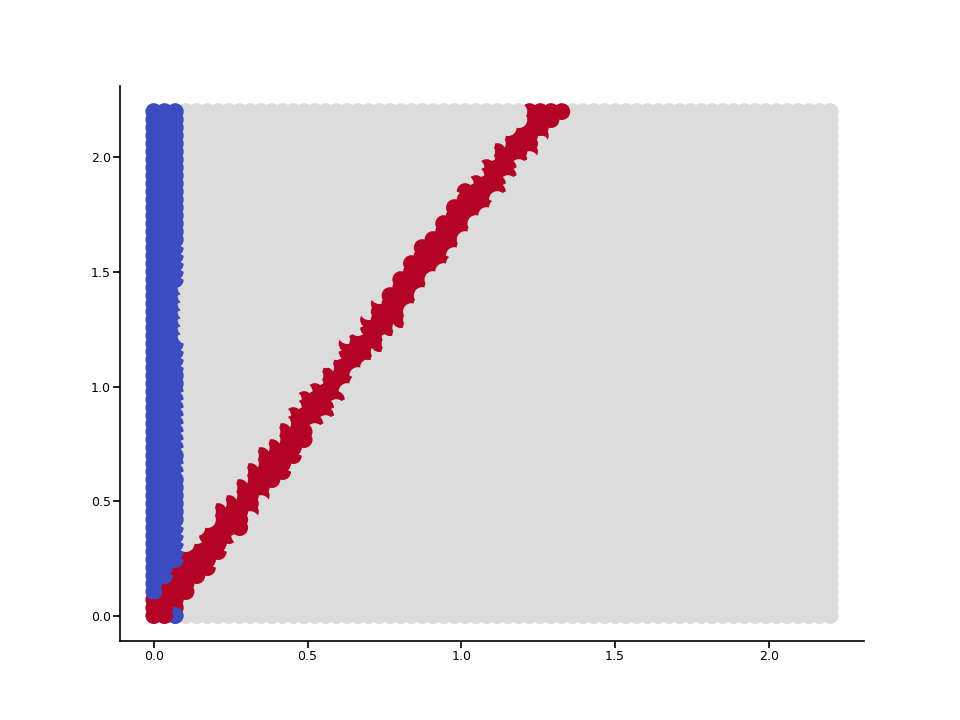

In [157]:
downsample_inds, dust, Fdfsf = utils.downsample_pointcloud(pca_fit, 4096, 4096, 'cosine')

xx = np.linspace(0, 2.2, concat_clusters.shape[-1])
yy = np.linspace(0, 2.2, concat_clusters.shape[-1])
xx, yy = np.meshgrid(xx, yy)
rr = np.stack((xx.ravel(), yy.ravel()), axis = -1)[downsample_inds]
plt.figure()

eps = 1e-1
line = np.ones(rr.shape[0])*255/2

line_mask = (np.abs(rr[:,0]) < eps) + (np.abs(rr[:,1] - rr[:,0]*np.tan(np.pi/3)) < eps)
line[(np.abs(rr[:,0]) < eps)] = 0
line[(np.abs(rr[:,1] - rr[:,0]*np.tan(np.pi/3)) < eps)] = 255
plt.scatter(*rr.T, c = line, s = 50, cmap = "coolwarm")
plt.show()

line_mask = np.ones(line_mask.shape).astype("bool")

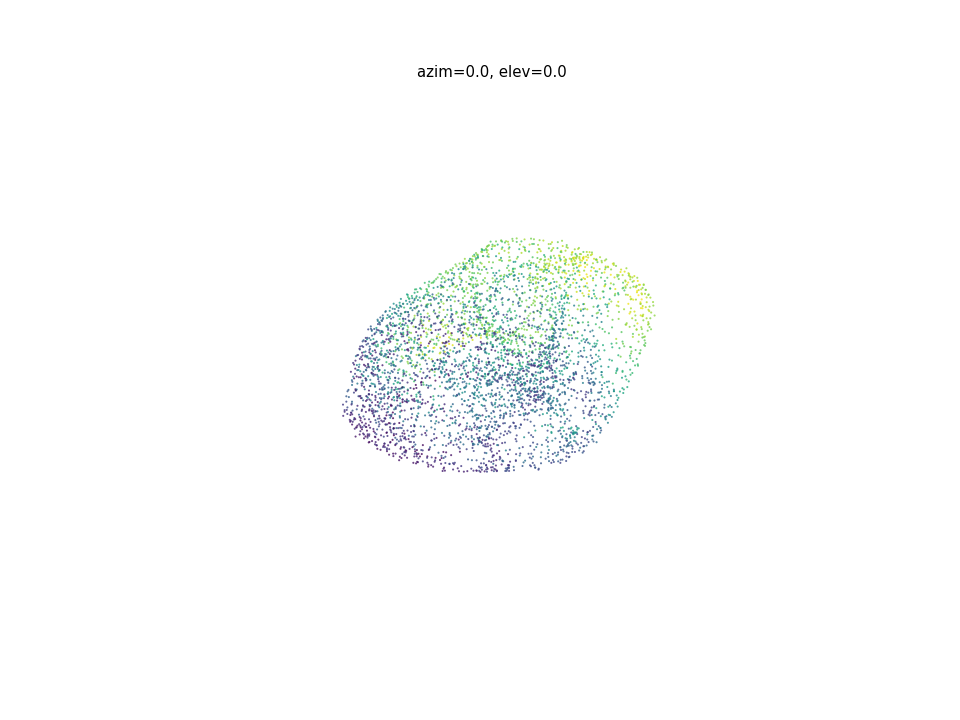

In [158]:
fig, ax = scatter3d(u[downsample_inds], pca_fit[downsample_inds,0], 1, 1, 
                    squeeze = False, s = 1, alpha = 0.8)

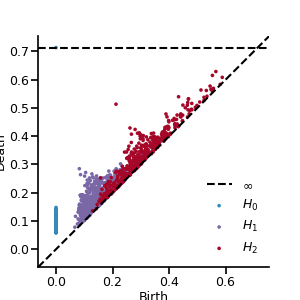

In [153]:
plt.figure(figsize = (2,2))
dgms = ripser(pca_fit[downsample_inds], n_perm = 512,  maxdim=2, coeff=47, metric =  'cosine')['dgms']
plot_diagrams(dgms, show=False, colormap = "bioAI.mplstyle", size = 3)
plt.show()    

In [25]:
"""
# And fit PCA + UMAP  to each cluster to see if they are actually toroidal
pca_fits = []
umap_fits = []
lowdim_labels = []

# accepted_maps.shape = (ng, nx, ny) --> nenvs, nx*ny, ng
g = accepted_maps.reshape((accepted_maps.shape[0], -1)).T
print(g.shape, labels.shape)

for ind in tqdm.tqdm(np.unique(labels)):
    selected = labels == ind
    # only do pca + umap if cluster contains more than 6 units. 
    if selected.sum() > 6:
        # mask out those with flat ratemaps (stddev = 0 everywhere)
        pca_fit, u = PCA_UMAP(g[:,selected])
        pca_fits.append(pca_fit)
        umap_fits.append(u)
        # save low dimensional projection
        lowdim_labels.append(ind)
        
"""

'\n# And fit PCA + UMAP  to each cluster to see if they are actually toroidal\npca_fits = []\numap_fits = []\nlowdim_labels = []\n\n# accepted_maps.shape = (ng, nx, ny) --> nenvs, nx*ny, ng\ng = accepted_maps.reshape((accepted_maps.shape[0], -1)).T\nprint(g.shape, labels.shape)\n\nfor ind in tqdm.tqdm(np.unique(labels)):\n    selected = labels == ind\n    # only do pca + umap if cluster contains more than 6 units. \n    if selected.sum() > 6:\n        # mask out those with flat ratemaps (stddev = 0 everywhere)\n        pca_fit, u = PCA_UMAP(g[:,selected])\n        pca_fits.append(pca_fit)\n        umap_fits.append(u)\n        # save low dimensional projection\n        lowdim_labels.append(ind)\n        \n'

In [26]:
"""
# Plot result
for u, pc, label, inds in zip(umap_fits, pca_fits, lowdim_labels, cell_inds):
    
    downsample_inds, d, Fdfsf = utils.downsample_pointcloud(pc, 10, 1024, 'cosine')
    dgms = ripser(pc[downsample_inds], n_perm = 512,  maxdim=2, coeff=47)['dgms']

    fig, ax = scatter3d(u[downsample_inds], pc[downsample_inds,0], 1, 1,squeeze = False, s = 10)
    ax[0,0].set_title(f"Cluster {label} No. cells: {len(inds)}")
    plt.show()
    
    fig, ax = plt.subplots(6,6, figsize = (2,2))
    show_maps = ratemaps[0][inds]
    
    for count in range(np.minimum(36, len(show_maps))):
        row = count // 6
        col = count % 6
        ax[row, col].imshow(show_maps[count])
        ax[row, col].axis("off")
        count += 1
    ax[0,0].clear()
    plot_diagrams(dgms, show=False, ax = ax[0,0], colormap = "bioAI.mplstyle", size = 3)
    plt.subplots_adjust(left = 0, top = 1, bottom = 0, right = 1, wspace = 0.025, hspace = 0.025)
    plt.show()    
"""


'\n# Plot result\nfor u, pc, label, inds in zip(umap_fits, pca_fits, lowdim_labels, cell_inds):\n    \n    downsample_inds, d, Fdfsf = utils.downsample_pointcloud(pc, 10, 1024, \'cosine\')\n    dgms = ripser(pc[downsample_inds], n_perm = 512,  maxdim=2, coeff=47)[\'dgms\']\n\n    fig, ax = scatter3d(u[downsample_inds], pc[downsample_inds,0], 1, 1,squeeze = False, s = 10)\n    ax[0,0].set_title(f"Cluster {label} No. cells: {len(inds)}")\n    plt.show()\n    \n    fig, ax = plt.subplots(6,6, figsize = (2,2))\n    show_maps = ratemaps[0][inds]\n    \n    for count in range(np.minimum(36, len(show_maps))):\n        row = count // 6\n        col = count % 6\n        ax[row, col].imshow(show_maps[count])\n        ax[row, col].axis("off")\n        count += 1\n    ax[0,0].clear()\n    plot_diagrams(dgms, show=False, ax = ax[0,0], colormap = "bioAI.mplstyle", size = 3)\n    plt.subplots_adjust(left = 0, top = 1, bottom = 0, right = 1, wspace = 0.025, hspace = 0.025)\n    plt.show()    \n'

In [75]:
pca_fit = PCA(n_components = 20).fit(gc)

In [76]:
m = pca_fit.explained_variance_ratio_

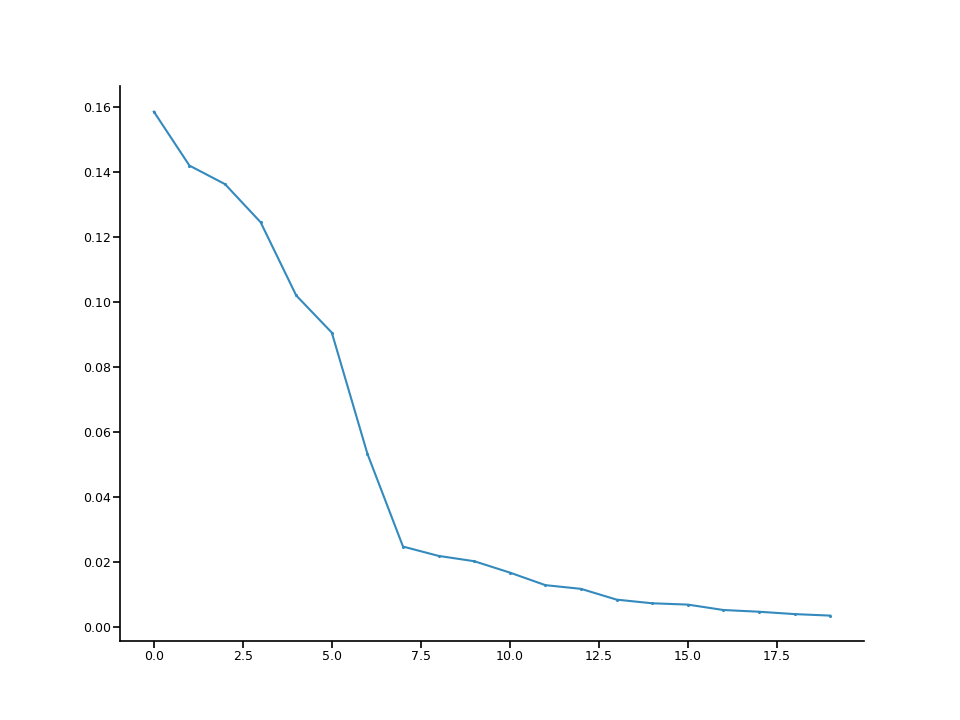

In [77]:
plt.figure()
plt.plot(np.arange(len(m)), m, "o-")
plt.show()